In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

## Creating the Diffuser

In this particular algorithm we require a diffuser in our circuit to assist in the amplitude amplification process.
The diffuser performs an additional rotation around the original guess of the algorithm which is the uniform superposition state |s>.
A diffuser is a more complex object which is not commonly used in quantum algorithms.

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(range(nqubits))
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(range(nqubits))
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    qc.x(range(nqubits))
    # Apply transformation |00..0> -> |s>
    qc.h(range(nqubits))
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

## Creating the Oracle

Defining the oracle in this cell we see that it's a function of the number of qubits and the state(s) we want to find from the database.
The oracle in this case corresponds to the identity matrix expect for a -1 in the position of the target state(s).
This means the application of the oracle in this circuit changes the phase of the target state(s).

In [4]:
def grover_oracle(n, marked_indices, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for marked_index in marked_indices:
        oracle_matrix[marked_index, marked_index] = -1
        
    qc.unitary(Operator(oracle_matrix), range(n))
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

## Creating Complete Quantum Circuit

In the following cell we design the quantum circuit.
We have chosen 5 qubits and 2 solutions which are generated as random numbers.
We then apply the oracle and diffuser a number times depending on how many times we rotate our quantum state until we obtain the winning state |w>.
The number of rotations or rotation angle depends on the number of qubits and the number of solutions.

[22, 6]


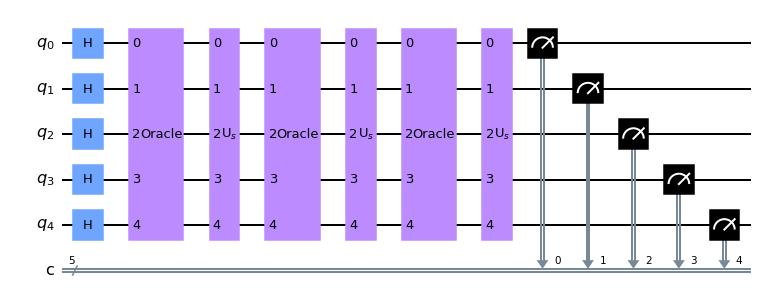

In [5]:
n=5
m=2 #Number of correct solutions
x = np.random.randint(2**n)
y = np.random.randint(2**n)
target = [x,y]
grover_circuit = QuantumCircuit(n,n)
grover_circuit.h(range(n))
for i in range(int((np.pi/4)*np.sqrt(2**n/m))):
    grover_circuit.append(grover_oracle(n, target), range(n))
    grover_circuit.append(diffuser(n), range(n))
grover_circuit.measure(range(n),range(n))
print(target)
grover_circuit.draw('mpl')

## Running Noiseless Simulation

Running the circuit we see that the two most measured states are the ones which we selected as the winning states.
Note: The states which were selected correspond to the ones printed after the previous cell but in binary form.
We can also see that even though we ran the circuit on a noiseless simulator the results still are not perfect. This is just statistical noise relating to the number of shots in our simulation.

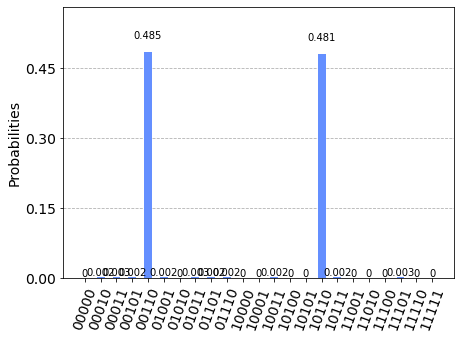

In [6]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(grover_circuit, backend,shots=1024).result().get_counts()
plot_histogram(job_sim)

## Simulating on Real Quantum Hardware

In the following cell we load our IBM Quantum accounts and check our possible providers.

In [41]:
from qiskit import IBMQ
provider = IBMQ.enable_account('API Token')
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='reczA7aZpklv6xtnQ')>]

We then check the list of possible devices for the least busy one.
Next, we get the coupling map and backend properties of the chosen device.

In [42]:
import qiskit.tools.jupyter

HW = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and not b.configuration().simulator and b.status().operational==True))
print(HW)
device = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_santiago')
coupling_map = device.configuration().coupling_map
backend_properties = device.properties()

ibmq_santiago


Using the coupling map and backend properties of the chosen device we create a noise model of the device. Using a noise model of a real quantum device we can run the circuit on our local devices without needing to queue for the hardware. This lets us obtain noisy results although they will still be slightly different from those run on real hardware.

We can clearly see that it's much more difficult to see which states were the target states.

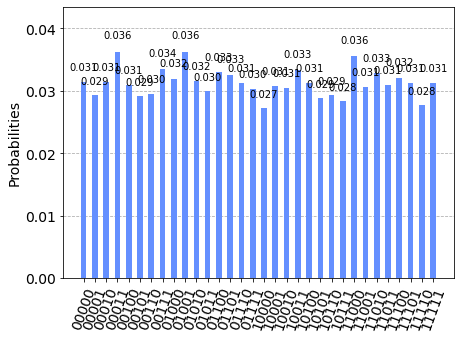

In [44]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise

# Creation of noise model and basis gate from backend properties

noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

bk = Aer.get_backend('qasm_simulator')
counts_noisy = execute(grover_circuit, shots=8192, backend=bk, coupling_map=coupling_map, 
                       basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts_noisy)

Next we run the circuit on the real quantum device which for the best comparison should be the same one we created the noise model from.

The results from the real device are much more noisy with no two states clearly measured more times than the other states.

Job Status: job has successfully run


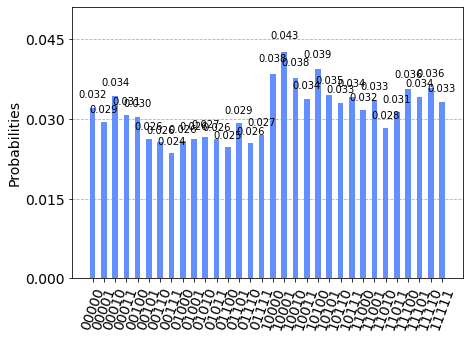

In [46]:
from qiskit.tools.monitor import job_monitor
bk_real = provider.get_backend('ibmq_santiago')
job = execute(grover_circuit, shots=8192, backend=bk_real)
job_monitor(job)
results = job.result()
counts_noisy_real = results.get_counts()
plot_histogram(counts_noisy_real)